## Causal vs non-Causal

In [ ]:
!pip install -U denoiser

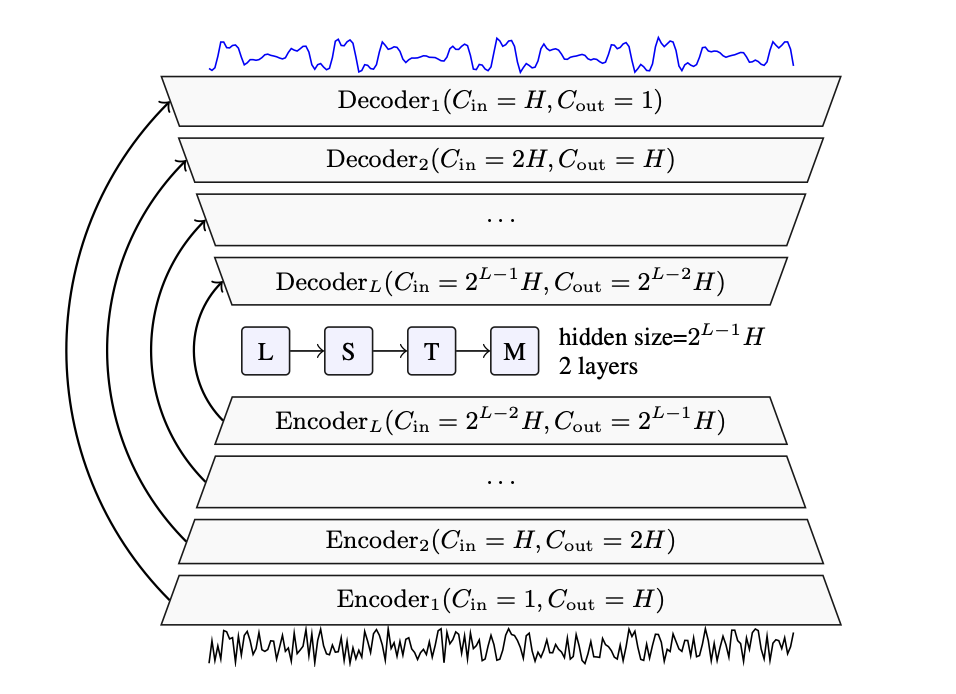

In [ ]:
from IPython import display as disp
import torch
import torchaudio
from denoiser import pretrained
from denoiser.dsp import convert_audio
from scipy.signal import wiener, convolve
from scipy.special import sinc
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib

In [ ]:
# Downloading a test file
!wget https://facebookresearch.github.io/denoiser/audio/noisy/alex_noisy.mp3

In [ ]:
model = pretrained.dns64()
wav, sr = torchaudio.load('./alex_noisy.mp3',format="mp3")
wav = convert_audio(wav, sr, model.sample_rate, model.chin)
with torch.no_grad():
    causal_denoised = model(wav[None])[0]
disp.display(disp.Audio(wav.numpy(), rate=model.sample_rate))
disp.display(disp.Audio(causal_denoised.numpy(), rate=model.sample_rate))

In [ ]:
wiener_denoised = wiener(wav.squeeze().numpy(), 7)
disp.display(disp.Audio(wav.numpy(), rate=sr))
disp.display(disp.Audio(wiener_denoised, rate=sr))

In [ ]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(window_size)

def plot_specs(wav1, wav2):
    freqs1, ts1, spec1 = scipy.signal.stft(wav1, sr, nperseg=n_fft)
    freqs2, ts2, spec2 = scipy.signal.stft(wav2, sr, nperseg=n_fft)
    norm_factor = np.amax(np.abs(spec1))/np.amax(np.abs(spec2))
    spec2 = spec2 * norm_factor

    fig, (ax11,ax21) = plt.subplots(2,1,figsize=(13,11))

    ax11.pcolormesh(ts1, freqs1, np.log(np.abs(spec1) + 1e-6),  shading='gouraud', cmap=matplotlib.colormaps['gist_heat'])
    ax11.set_ylabel('Frequency (Hz)')
    ax11.set_xlabel('Time')

    im2=ax21.pcolormesh(ts2, freqs2, np.log(np.abs(spec2) + 1e-6),  shading='gouraud', cmap=matplotlib.colormaps['gist_heat'])
    ax21.set_ylabel('Frequency [Hz]')
    ax21.set_xlabel('Time')

    plt.show()

def visualize_audio(wav, sr):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    disp.display(disp.Audio(wav, rate=sr))

plot_specs(wav.squeeze().numpy(), wiener_denoised.squeeze())


## Sinc filter

With parameter $B$  is defined as

$$
    h(t) = 2B sinc(2Bt)
$$

where $sinc$ is the normalized sinc function

$$
    sinc(x) = {sin(\pi t) \over \pi t}
$$

When FT is taken it turns out that it is a rectangular frequency filter. Thus, it removes all frequencies above some level $B$:
$$
H(f) = \begin{cases}
            0, & |f| > B\\
            {1 \over 2}, & |f| = B\\
            1, & |f| < B
        \end{cases}
$$

One of the constructions of rectangular low- and hi-pass filters comes from the usage of the sinc function.

In [ ]:
fc = 0.2
fc1 = 0.1
N = wav.shape[1]
sinc_filter = 2 * fc * sinc(2 * fc * (np.arange(N) - (N - 1) / 2.))
sinc_filter1 = 2 * fc1 * sinc(2 * fc1 * (np.arange(N) - (N - 1) / 2.))

plt.figure(figsize=(4, 4))
plt.plot((np.arange(N) - (N - 1) / 2.),sinc_filter)
plt.grid(True)
plt.show()

In [ ]:
filtered_wav = convolve(wav.squeeze().numpy(), sinc_filter - sinc_filter1, mode="same")

plot_specs(wav.squeeze().numpy(), filtered_wav)

In [ ]:
fc = 0.2
N = 201
sinc_filter_small = sinc(2 * fc * (np.arange(N) - (N - 1) / 2.))

plt.figure(figsize=(7, 7))
plt.plot(sinc_filter_small)
plt.grid(True)
plt.show()

In [ ]:
filtered_wav = convolve(wav.squeeze().numpy(), sinc_filter_small, mode="same")

plot_specs(wav.squeeze().numpy(), filtered_wav)

In [ ]:
w = np.blackman(N)
sinc_filter_small = sinc_filter_small * w
sinc_filter_small /= sinc_filter_small.sum()

plt.figure(figsize=(7, 7))
plt.plot(sinc_filter_small)
plt.grid(True)
plt.show()

filtered_wav = convolve(wav.squeeze().numpy(), sinc_filter_small, mode="same")


plot_specs(wav.squeeze().numpy(), filtered_wav)
# plot_spec(torch.from_numpy(filtered_wav))

In [ ]:
visualize_audio(torch.from_numpy(filtered_wav), sr)
visualize_audio(wav, sr)

In [ ]:
model_nc = pretrained.valentini_nc()

with torch.no_grad():
    nc_denoised = model_nc(wav[None])[0]
disp.display(disp.Audio(wav.numpy(), rate=model.sample_rate))
disp.display(disp.Audio(nc_denoised.numpy(), rate=model.sample_rate))

In [ ]:
plot_specs(causal_denoised.squeeze().numpy(), nc_denoised.squeeze().numpy())

In [ ]:
frame_size = 16 * 40 # 40ms
n_chunks = wav.shape[1] // frame_size

chunked_wav = torch.stack(torch.chunk(wav.squeeze(), n_chunks)[:-1], dim=0)
print(chunked_wav.shape)
with torch.no_grad():
    nc_denoised_chunked = model_nc(chunked_wav)
    causal_denoised_chunked = model(chunked_wav)
disp.display(disp.Audio(causal_denoised_chunked.reshape(-1).numpy(), rate=model.sample_rate))
disp.display(disp.Audio(nc_denoised_chunked.reshape(-1).numpy(), rate=model.sample_rate))

In [ ]:
import librosa

def overlap_add(model, wav: np.ndarray, chunk_size):
    stride = chunk_size // 2
    n = len(wav) - chunk_size
    n_chunks = n // stride + 1 + (n % stride > 0)
    n_pad = stride - n % stride

    wav_padded = np.pad(wav, (0, n_pad), 'constant', constant_values=(0, 1e-5))

    chunks = torch.from_numpy(librosa.util.frame(wav_padded, frame_length=chunk_size, hop_length=stride)).permute(1, 0)

    with torch.no_grad():
        chunks = model(chunks)[:, 0, :]

    n_chunks = chunks.shape[0]
    first = chunks[0, 0:stride]
    last = chunks[-1, stride:]

    overlapped_chunks = chunks.reshape(-1)[stride:chunk_size * (n_chunks - 1) + stride].reshape(-1, chunk_size)
    window_vec = torch.sin(torch.arange(stride) / (stride - 1)) * (np.pi / 2)
    kernel_matrix = torch.zeros(2*stride, stride, dtype=overlapped_chunks.dtype)
    kernel_matrix[:stride, :] = torch.diag(1 - window_vec)
    kernel_matrix[stride:, :] = torch.diag(window_vec)
    sum_overlapped_chunks = (overlapped_chunks @ kernel_matrix).reshape(-1)

    overlap_added_wav = torch.cat((first, sum_overlapped_chunks, last), dim=-1)
    return overlap_added_wav

overadd_wav = overlap_add(model, wav.squeeze().numpy(), chunk_size=650)
visualize_audio(overadd_wav, sr)

In [ ]:
overadd_wav = overlap_add(model_nc, wav.squeeze().numpy(), chunk_size=650)
visualize_audio(overadd_wav, sr)

In [ ]:
from denoiser.demucs import DemucsStreamer

streamer = DemucsStreamer(model)
with torch.no_grad():
    estimate = torch.cat([
        streamer.feed(wav),
        streamer.flush()], dim=1)[None]

visualize_audio(estimate.squeeze(), sr)

In original demucs implementation there are 3 main techniques to enhance quality on evaluation of real-time model:
- Normalize audio with variance estimated during evaluation;

- Padding with history before upsampling and downsampling;

- Return extra strides from model inference.

In [ ]:
import math
from denoiser.resample import upsample2, downsample2

def demucs_process(model, wav):
    streamer = DemucsStreamer(model)
    resample_buffer = streamer.resample_buffer
    stride = streamer.stride
    resample = model.resample
    n_frames = 0
    total_variance = 0

    resample_in = torch.zeros(1, resample_buffer)
    resample_out = torch.zeros(1, resample_buffer)

    stream = wav
    outs = []
    while stream.shape[1] >= streamer.total_length:
        n_frames += 1
        frame = stream[:, :streamer.total_length]
        if model.normalize:
            mono = frame.mean(0)
            variance = (mono**2).mean()
            total_variance = variance / n_frames + (1 - 1 / n_frames) * total_variance # update variance
            frame = frame / (model.floor + math.sqrt(total_variance)) # norm audio by variance
        padded_frame = torch.cat([resample_in, frame], dim=-1)
        resample_in[:] = frame[:, stride - resample_buffer:stride]
        frame = padded_frame

        if resample == 4:
            frame = upsample2(upsample2(frame))
        elif resample == 2:
            frame = upsample2(frame)
        frame = frame[:, resample * resample_buffer:]  # remove pre sampling buffer
        frame = frame[:, :resample * streamer.frame_length]  # remove extra samples after window

        out, extra = streamer._separate_frame(frame)
        padded_out = torch.cat([resample_out, out, extra], 1)
        resample_out[:] = out[:, -resample_buffer:]
        if resample == 4:
            out = downsample2(downsample2(padded_out))
        elif resample == 2:
            out = downsample2(padded_out)
        else:
            out = padded_out

        out = out[:, resample_buffer // resample:]
        out = out[:, :stride]

        if model.normalize:
            out *= math.sqrt(total_variance)

        outs.append(out)
        stream = stream[:, stride:]

    out = torch.cat(outs, 1)

    return out

In [ ]:
with torch.no_grad():
    estimate = demucs_process(model, wav)

In [ ]:
visualize_audio(estimate.squeeze(), sr)

## Complexity estimation

There are certain metrics to compute how suitable you are for realtime setting: they include both model complexity and performance metrics.

* RTF(realtime factor): time of processing of 1 chunk of audio divided by audio length (in seconds)
* Processing time (per second of audio)
* FLOps or MACs: number of arithmetic operations needed to pproduce a result (with input of 1 sec audio)
* Model complexity: number of parameters and/or size in bytes

In [ ]:
from thop import profile

def compute_gflops_and_model_size(model,inputSample):
    macs, params = profile(model, inputs=(inputSample,), verbose=False)
    #GFlops = macs * 2.0 / pow(10, 9)#a rough estimate
    GMacs = macs / 1e9
    params_M = params/1e6
    return params_M, GMacs

In [ ]:
print("SR", sr)
wav1Sec = wav[...,:sr]
print(wav1Sec)

In [ ]:
compute_gflops_and_model_size(model_nc,wav1Sec)

In [ ]:
compute_gflops_and_model_size(model,wav1Sec)

Demucs also has a short way to compute delay and RTF on your device:

In [ ]:
!python -m denoiser.demucs --hidden=48 --num_threads=4

It is given in detail [in the repo](https://github.com/facebookresearch/denoiser/blob/main/denoiser/demucs.py).